# Linear Regression (Easy)

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

This task involves determining the coefficients $\beta \in \mathbb{R}^{1+N}$, in a dataset $\left\lbrace (x_1,y_1) \dots, (x_L,y_L) \right\rbrace \subseteq \mathbb{R}^N \times \mathbb{R}$ of varying size $L$.
That is, there is a vector $\beta$ such that, for $1 \leq i \leq L$,
$$
y_i = \begin{bmatrix} 1 & x_i^\top \end{bmatrix} \beta
$$

Once $\mathrm{span}\!\left\lbrace x_1, \dots, x_L \right\rbrace = \mathbb{R}^N$ (which is almost certain when sampling $L \geq N$ data points), the problem may be solved exactly using least squares estimation:
$$
\hat{\beta} = \left( X^\top X \right)^{-1} X^\top y
$$
Since the relationship is exact, the optimal residuals $y - \hat{y}$ should be zero.

The task is evaluated using R-squared of the predictions made using the estimated coefficients $\hat{\beta}$, on a set of $1000$ additional unseen points $\left\lbrace (x_{L+1},y_{L+1}), \dots, (x_{L+1000},y_{L+1000}) \right\rbrace$:

In [ ]:
from torch import Tensor

def get_r_squared(
        target: Tensor,
        mean: Tensor,
        prediction: Tensor,
) -> float:
    B = target.shape[:-1]
    L = target.shape[-1]
    assert prediction.shape == (*B, L)
    assert mean.shape == B

    tss = (target - mean.unsqueeze(dim=-1)).square().sum(dim=-1)
    rss = (target - prediction).square().sum(dim=-1)
    assert tss.shape == rss.shape == B

    r_squared = torch.where(tss > 0.0, 1.0 - (rss / tss), 0.0)
    assert r_squared.shape == B
    return float(r_squared.mean())

## Data

During training, the data generation process is as follows:

- sample a length $L$ uniformly from $1$ to $L_\mathrm{max}$ inclusive
- sample a mean $\mu \in \mathbb{R}^N \sim \mathcal{N}(0,I)$
- sample $x_1, \dots, x_L \sim \mathcal{N}(\mu,I)$
- sample coefficients $\beta \in \mathbb{R}^{1+N}$
- for $1 \leq i \leq L$, compute $y_i = \begin{bmatrix} 1 & x_i^\top \end{bmatrix} \beta$

For these experiments we use $L_\mathrm{max} = 100$.

During evaluation, we evalute $1000$ times for each value of $L$ from $2$ to $2 L_\mathrm{max}$ and plot the r_squared curve.

In [3]:
def get_y(beta: Tensor, x: Tensor) -> Tensor:
    B, L, I = x.shape
    assert beta.shape == (B, 1+I)
    y = beta[...,None,0] + (x * beta[...,None,1:]).sum(dim=-1)
    assert y.shape == (B, L)
    return y

def get_uniform_batch(
        *,
        length: int,
        input_dim: int,
        batch_size: int,
        rng: torch.Generator,
        device: torch.device = device,
) -> tuple[Tensor, Tensor]:
    B = batch_size
    L = length
    N = input_dim
    mean = torch.randn((B, N), generator=rng, device=device)
    x = torch.randn((B, L, N), generator=rng, device=device)
    x = x + mean.unsqueeze(dim=-2)

    beta = torch.randn((B, 1+N), generator=rng, device=device)
    y = get_y(beta, x)
    return x, y

L_max = 100

def get_mixed_batch(
        *,
        input_dim: int,
        batch_size: int,
        max_length: int = L_max,
        rng: torch.Generator,
        device: torch.device = device,
) -> tuple[Tensor, Tensor, Tensor]:
    B = batch_size
    I = input_dim

    length = torch.randint(
        low=1,
        high=max_length + 1,
        size=(B,),
        generator=rng,
        device=device,
    )
    L = int(length.max())

    x, y = get_uniform_batch(
        length=L,
        input_dim=I,
        batch_size=B,
        rng=rng,
        device=device,
    )
    mask = torch.arange(L, device=device).unsqueeze(dim=0) < length.unsqueeze(dim=-1)
    return x, y, mask

## Model

In [ ]:
from typing import Optional

import torch
from torch import nn, Tensor


class LinearRegressionModel(nn.Module):
    def __init__(
            self,
            input_dim: int,
            embed_dim: int,
            num_heads: int,
            num_layers: int,
    ):
        super().__init__()

        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_layers = num_layers

        self.x_ff = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=embed_dim),
            nn.GELU(),
            nn.Linear(in_features=embed_dim, out_features=embed_dim),
            nn.GELU(),
        )
        self.y_ff = nn.Sequential(
            nn.Linear(in_features=1, out_features=embed_dim),
            nn.GELU(),
            nn.Linear(in_features=embed_dim, out_features=embed_dim),
            nn.GELU(),
        )
        if num_layers > 0:
            layer = nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                activation="gelu",
                dropout=0.0,
                dim_feedforward=(embed_dim*4),
                norm_first=True,
                batch_first=True,
            )
            self.transformer = nn.TransformerEncoder(layer, num_layers=num_layers)
        self.coefficients_ff = nn.Linear(in_features=embed_dim, out_features=1+input_dim)

    def forward(
            self,
            x: Tensor,
            y: Tensor,
            *,
            mask: Optional[Tensor] = None,
    ) -> tuple[Tensor, Tensor]:
        B, L, I = x.shape
        assert I == self.input_dim
        assert y.shape == (B, L)

        E = self.embed_dim

        x_embeds = self.x_ff(x)
        assert isinstance(x_embeds, Tensor)
        y_embeds = self.y_ff(y.unsqueeze(dim=-1))
        assert isinstance(y_embeds, Tensor)
        assert x_embeds.shape == y_embeds.shape == (B, L, E)

        embeds = x_embeds + y_embeds

        if self.num_layers > 0:
            if mask is None:
                transformer_mask = None
            else:
                assert mask.shape == (B, L)
                transformer_mask = ~mask
            embeds = self.transformer(embeds, src_key_padding_mask=transformer_mask)
            assert isinstance(embeds, Tensor)
            assert embeds.shape == (B, L, E)

        if mask is not None:
            embeds = torch.where(mask.unsqueeze(dim=-1), embeds, 0.0)
            count = mask.sum(dim=-1, keepdim=True)
        else:
            count = L
        pooled = embeds.sum(dim=-2) / count
        assert pooled.shape == (B, E)

        beta_hat = self.coefficients_ff(pooled)
        assert isinstance(beta_hat, Tensor)
        assert beta_hat.shape == (B, 1+I)

        y_hat = get_y(beta_hat, x)
        assert y_hat.shape == (B, L)
        error = y - y_hat
        if mask is not None:
            error = torch.where(mask, error, 0.0)
            count = mask.sum()
        else:
            count = B*L
        loss = error.square().sum() / count

        return beta_hat, loss


## Experiment

In [5]:
from IPython.display import clear_output
from matplotlib import pyplot as plt

lengths = list(range(2, 2*L_max+1))

train_steps_per_epoch = 1000
train_batch_size = 100
eval_batch_size = 100
epochs_without_improvement_to_stop = 10

def experiment(
    *,
    input_dim: int,
    embed_dim: int,
    num_heads: int,
    num_layers: int,
    seed: int = 0,
) -> float:
    torch.manual_seed(seed)

    model = LinearRegressionModel(
        input_dim=input_dim,
        embed_dim=embed_dim,
        num_heads=num_heads,
        num_layers=num_layers,
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())

    mean_loss_acc: list[float] = []
    r_squared_accs: list[list[float]] = []
    mean_r_squared_acc: list[float] = []
    best_epoch: int = 0
    best_mean_r_squared: float = -float("inf")

    train_rng = torch.Generator(device=device).manual_seed(seed)

    epoch = 0
    while True:
        if epoch - best_epoch > epochs_without_improvement_to_stop:
            break

        total_loss = 0.0
        if epoch > 0:
            model.train()
            for i in range(train_steps_per_epoch):
                x, y, mask = get_mixed_batch(
                    input_dim=input_dim,
                    batch_size=train_batch_size,
                    rng=train_rng,
                )
                _, loss = model(x, y, mask=mask)
                assert isinstance(loss, Tensor)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                total_loss += float(loss)
        mean_loss = total_loss / train_steps_per_epoch
        mean_loss_acc.append(mean_loss)

        eval_rng = torch.Generator(device=device).manual_seed(0)
        with torch.no_grad():
            r_squared_acc: list[float] = []
            model.eval()
            for L in lengths:
                x, y = get_uniform_batch(
                    length=L+1000,
                    input_dim=input_dim,
                    batch_size=eval_batch_size,
                    rng=eval_rng,
                )
                beta, _ = model(x[:,:-1000,:], y[:,:-1000])
                assert isinstance(beta, Tensor)
                target = y[:,-1000:]
                mean = y[:,:-1000].mean(dim=-1)
                prediction = get_y(beta, x[:,-1000:,:])
                assert isinstance(prediction, Tensor)
                r_squared = get_r_squared(
                    target=target,
                    mean=mean,
                    prediction=prediction,
                )
                r_squared_acc.append(r_squared)
            r_squared_accs.append(r_squared_acc)
            mean_r_squared = sum(r_squared_acc) / len(r_squared_acc)
            mean_r_squared_acc.append(mean_r_squared)

            if mean_r_squared > best_mean_r_squared:
                best_mean_r_squared = mean_r_squared
                best_epoch = epoch

        plt.figure(figsize=(8.0, 6.0))
        e = 1
        while e <= epoch:
            plt.plot(lengths, r_squared_accs[e], label=f"Epoch {e}")
            e *= 2
        plt.plot(lengths, r_squared_accs[best_epoch], label=f"Best Epoch ({best_epoch})")
        plt.xlabel("Length")
        plt.xlim(2, 2*L_max)
        plt.xscale("log")
        plt.ylabel("R\u00b2")
        plt.ylim(top=1.0)
        plt.legend()
        clear_output(wait=True)
        plt.show()
        for e, (ml, mp) in enumerate(zip(mean_loss_acc, mean_r_squared_acc)):
            if e == 0:
                continue
            print(
                f"Epoch {e:03d}: mean loss = {ml:.3f} | mean R\u00b2 = {mp:.3f}"
                + (" (*)" if best_epoch == e else "")
            )

        epoch += 1

    return best_mean_r_squared

**TODO**: ablations

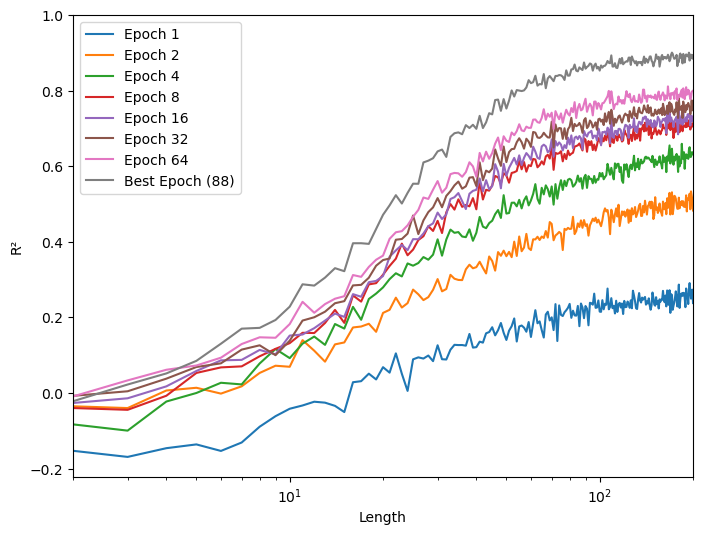

Epoch 001: mean loss = 29.862 | mean R² = 0.186
Epoch 002: mean loss = 15.284 | mean R² = 0.406
Epoch 003: mean loss = 11.151 | mean R² = 0.471
Epoch 004: mean loss = 9.574 | mean R² = 0.515
Epoch 005: mean loss = 8.340 | mean R² = 0.546
Epoch 006: mean loss = 7.624 | mean R² = 0.578
Epoch 007: mean loss = 7.158 | mean R² = 0.579
Epoch 008: mean loss = 6.806 | mean R² = 0.593
Epoch 009: mean loss = 6.577 | mean R² = 0.593
Epoch 010: mean loss = 6.292 | mean R² = 0.583
Epoch 011: mean loss = 6.240 | mean R² = 0.606
Epoch 012: mean loss = 6.086 | mean R² = 0.606
Epoch 013: mean loss = 5.955 | mean R² = 0.612
Epoch 014: mean loss = 5.912 | mean R² = 0.615
Epoch 015: mean loss = 5.692 | mean R² = 0.605
Epoch 016: mean loss = 5.637 | mean R² = 0.612
Epoch 017: mean loss = 5.628 | mean R² = 0.623
Epoch 018: mean loss = 5.496 | mean R² = 0.617
Epoch 019: mean loss = 5.402 | mean R² = 0.623
Epoch 020: mean loss = 5.378 | mean R² = 0.626
Epoch 021: mean loss = 5.333 | mean R² = 0.628
Epoch 022:

In [ ]:
experiment(
    input_dim=32,
    embed_dim=128,
    num_heads=4,
    num_layers=4,
)